<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/tasks/forced-alignment.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/tasks/forced-alignment.ipynb)

# Force alignment using k2 for CTC models.

This module provides an abstract class, `Aligner`, for force alignment using k2 for CTC models.
Besides, it also provides a concrete class, `CTCAligner`, for force alignment using k2
specifically for a pre-trained CTC model and a tokeniser (`CTCTextEncoder`).
Note that we must make sure that the blank symbol is index 0 in the tokeniser's vocabulary.

We support three different ways of conducting force alignment:
1. One audio file and one transcript at a time.
2. A batch of audio files and transcripts.
3. A csv file containing the audio file paths and transcripts.
    In this case, the csv file should follow the standard speechbrain csv format with a header line as follows:

    ```
    ID, duration, wav, spk_id, wrd
    ```

When token-level alignment is conducted, for one single audio file or a batch of audio files,
the aligning method will return a list of lists of integers,
where each integer represents the index of the token in the tokeniser's vocabulary.
For example, if the tokeniser's vocabulary is `['<blank>', '<unk>', 'a', 'b', 'c']`,
then the returned list of lists of integers may look like `[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]`.
For an input of csv file, the aligning method will return a dictionary (`Dict[str, List[int]]`),
where the keys are the IDs of the audio files and the values are the list of token indexes.

When word-level alignment is conducted, for one single audio file or a batch of audio files,
the aligning method will return a list of lists of tuples,
where each tuple represents (`start_frame` (int, including), `end_frame` (int, including), `word` (str)).
For example, if the transcript is 'hello word', and there are 20 frames in the audio file,
then the returned list of lists of tuples may look like `[[(3, 10, 'hello'), (11, 16, 'word')]]`.

For an input of csv file, the aligning method will return a pandas.`DataFrame`,
where the columns are `['ID', 'word', 'start', 'end']`, and note that the start and end are in seconds.
However, if the `frame_shift` for the method, `align_csv_word`, is `None`, then the start and end will be in frames.

Author:
* Zeyu Zhao 2024


In [1]:
# For this tutorial, speechbrain and k2 are assumed to be pre-installed, see instructions at:
# * https://speechbrain.readthedocs.io/en/latest/installation.html
# * https://k2-fsa.github.io/k2/installation/index.html
from speechbrain.inference import EncoderASR
from speechbrain.integrations.k2_fsa.align import CTCAligner

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load_if_possible


In [6]:
# This aligner depends on having a pretrained CTC-based ASR model
# Let's load a pretrained one and demonstrate that it works
from speechbrain.utils.fetching import fetch
wav = fetch("example.wav", source="speechbrain/asr-wav2vec2-commonvoice-en")
asr_model = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech")
asr_model.transcribe_file(str(wav))

INFO:speechbrain.utils.fetching:Fetch example.wav: Fetching from HuggingFace Hub 'speechbrain/asr-wav2vec2-commonvoice-en' if not cached
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/home/competerscience/Documents/Repositories/speechbrain/docs/tutorials/tasks/pretrained_models/asr-wav2vec2-librispeech/hyperparams.yaml'
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/asr-wav2vec2-librispeech.
INFO:speechbrain.utils.fetching:Fetch wav2vec2.ckpt: Using symlink found at '/home/competerscience/Documents/Repositories/speechbrain/docs/tutorials/tasks/pretrained_models/asr-wav2vec2-librispeech/wav2vec2.ckpt'
DEBUG:

'THE BIRCH CANOE SLID ON THE SMOOTH PLANKS'

Text(0, 0.5, 'Amplitude')

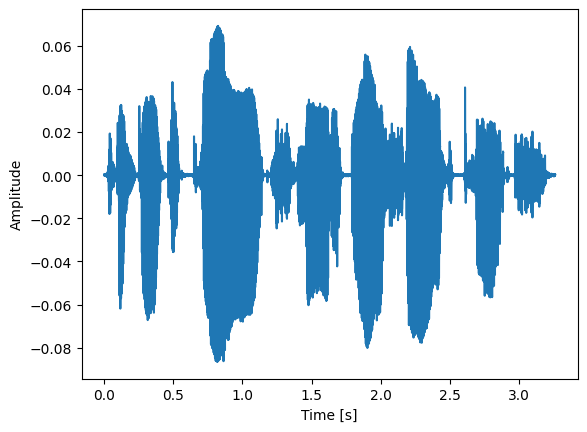

In [9]:
# Let's load the audio file and display it here
import matplotlib.pyplot as plt
import torchaudio
import numpy as np

audio, fs = torchaudio.load(wav)
xs = np.arange(len(audio[0])) / fs
plt.plot(xs, audio[0])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

In [12]:
# Okay, run the alignment
aligner = CTCAligner(model=asr_model, tokenizer=asr_model.tokenizer, device=asr_model.device)
alignment = aligner.align_audio_to_words(wav, "THE BIRCH CANOE SLID ON THE SMOOTH PLANKS", frame_shift=0.02)
alignment

[(0.1, 0.14, 'THE'),
 (0.26, 0.5, 'BIRCH'),
 (0.68, 0.98, 'CANOE'),
 (1.3800000000000001, 1.62, 'SLID'),
 (1.82, 1.8800000000000001, 'ON'),
 (1.96, 2.02, 'THE'),
 (2.16, 2.48, 'SMOOTH'),
 (2.64, 3.02, 'PLANKS')]

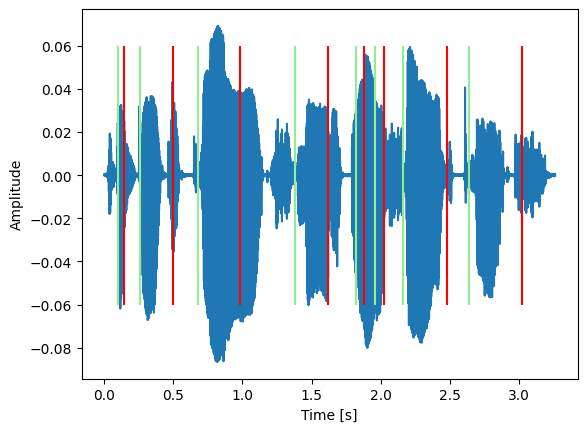

In [16]:
plt.plot(xs, audio[0])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

# Add to the chart all the word boundaries
plt.vlines([start for start, _, _ in alignment], ymin=-0.06, ymax=0.06, color="lightgreen")
plt.vlines([stop for _, stop, _ in alignment], ymin=-0.06, ymax=0.06, color="red")
plt.show()

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```